In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import zscore

import geopandas as gpd
import h3

from datetime import timedelta

In [16]:
# read in data that has been cleaned but where time data has not been handled yet
chicago_trips = pd.read_csv("data/Chicago_Trips_hex_res.csv")

In [3]:
chicago_trips.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,pickup_h3_low_resolution,dropoff_h3_low_resolution,pickup_h3_medium_resolution,dropoff_h3_medium_resolution,pickup_h3_high_resolution,dropoff_h3_high_resolution
0,0000184e7cd53cee95af32eba49c44e4d20adcd8,f538e6b729d1aaad4230e9dcd9dc2fd9a168826ddadbd6...,2024-01-19 17:00:00,2024-01-19 18:00:00,4051.0,17.12,1.703198e+10,1.703132e+10,76.0,32.0,...,POINT (-87.9030396611 41.9790708201),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),832759fffffffff,832664fffffffff,85275937fffffff,852664c3fffffff,88275934edfffff,882664c1e3fffff
1,000074019d598c2b1d6e77fbae79e40b0461a2fc,aeb280ef3be3e27e081eb6e76027615b0d40925b84d3eb...,2024-01-05 09:00:00,2024-01-05 09:00:00,517.0,3.39,1.703106e+10,1.703108e+10,6.0,8.0,...,POINT (-87.6559981815 41.9442266014),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),832664fffffffff,832664fffffffff,852664c3fffffff,852664c3fffffff,882664c163fffff,882664c1edfffff
2,00007c3e7546e2c7d15168586943a9c22c3856cf,8ef1056519939d511d24008e394f83e925d2539d668a00...,2024-01-18 19:15:00,2024-01-18 19:30:00,1004.0,1.18,1.703184e+10,1.703184e+10,32.0,32.0,...,POINT (-87.6327464887 41.8809944707),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),832664fffffffff,832664fffffffff,852664c3fffffff,852664c3fffffff,882664c1a9fffff,882664c1a9fffff
3,0000cf293ada965f89a98c8ccfae7b0ce3a03e41,37073e8c9e454886fe4a916f80a9a3478570e7dd3e663f...,2024-01-04 07:15:00,2024-01-04 07:30:00,484.0,1.59,1.703128e+10,1.703132e+10,28.0,32.0,...,POINT (-87.642648998 41.8792550844),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),832664fffffffff,832664fffffffff,852664c3fffffff,852664c3fffffff,882664c1adfffff,882664c1e3fffff
4,0001235258d46a21317b6691ade9386c4d7e02c4,715b091e1001d1c17938c3b5ed7e23d926c53150ee2d0f...,2024-01-25 11:15:00,2024-01-25 11:30:00,1686.0,13.01,1.703132e+10,1.703198e+10,32.0,56.0,...,POINT (-87.6209929134 41.8849871918),41.785999,-87.750934,POINT (-87.7509342894 41.785998518),832664fffffffff,832664fffffffff,852664c3fffffff,85266453fffffff,882664c1e3fffff,8826645219fffff


# Aggregation: Hourly

In [ ]:
# Create a copy to avoid modifying original
chicago_trips_hourly = chicago_trips.copy()

# Convert timestamp to datetime
chicago_trips_hourly["Trip Start Timestamp"] = pd.to_datetime(
    chicago_trips_hourly["Trip Start Timestamp"], format="%Y-%m-%d %H:%M:%S", errors="coerce"
)

# Floor to nearest hour
chicago_trips_hourly['Trip Start Timestamp Hour'] = chicago_trips_hourly['Trip Start Timestamp'].dt.floor('H')

# Group by H3 and hourly time
trip_counts_low_res = chicago_trips_hourly.groupby(
    ['pickup_h3_low_resolution', 'Trip Start Timestamp Hour']
).size().reset_index(name='Hourly Trips Low Resolution')

trip_counts_medium_res = chicago_trips_hourly.groupby(
    ['pickup_h3_medium_resolution', 'Trip Start Timestamp Hour']
).size().reset_index(name='Hourly Trips Medium Resolution')

trip_counts_high_res = chicago_trips_hourly.groupby(
    ['pickup_h3_high_resolution', 'Trip Start Timestamp Hour']
).size().reset_index(name='Hourly Trips High Resolution')

# Get all hexes and hours
all_hexes_low_resolution = chicago_trips_hourly['pickup_h3_low_resolution'].unique()
all_hexes_medium_resolution = chicago_trips_hourly['pickup_h3_medium_resolution'].unique()
all_hexes_high_resolution = chicago_trips_hourly['pickup_h3_high_resolution'].unique()

all_hours = pd.date_range(
    start=chicago_trips_hourly['Trip Start Timestamp Hour'].min(),
    end=chicago_trips_hourly['Trip Start Timestamp Hour'].max(),
    freq='H'
)

# Cartesian product of hex and time
full_index_low_resolution = pd.MultiIndex.from_product(
    [all_hexes_low_resolution, all_hours],
    names=['pickup_h3_low_resolution', 'Trip Start Timestamp Hour']
)
hourly_trips_low_resolution = pd.DataFrame(index=full_index_low_resolution).reset_index()

full_index_medium_resolution = pd.MultiIndex.from_product(
    [all_hexes_medium_resolution, all_hours],
    names=['pickup_h3_medium_resolution', 'Trip Start Timestamp Hour']
)
hourly_trips_medium_resolution = pd.DataFrame(index=full_index_medium_resolution).reset_index()

full_index_high_resolution = pd.MultiIndex.from_product(
    [all_hexes_high_resolution, all_hours],
    names=['pickup_h3_high_resolution', 'Trip Start Timestamp Hour']
)
hourly_trips_high_resolution = pd.DataFrame(index=full_index_high_resolution).reset_index()

# Merge trip counts
full_hourly_trips_low_res = hourly_trips_low_resolution.merge(
    trip_counts_low_res, on=['pickup_h3_low_resolution', 'Trip Start Timestamp Hour'], how='left'
)
full_hourly_trips_medium_res = hourly_trips_medium_resolution.merge(
    trip_counts_medium_res, on=['pickup_h3_medium_resolution', 'Trip Start Timestamp Hour'], how='left'
)
full_hourly_trips_high_res = hourly_trips_high_resolution.merge(
    trip_counts_high_res, on=['pickup_h3_high_resolution', 'Trip Start Timestamp Hour'], how='left'
)

# Fill NaNs with 0
full_hourly_trips_low_res['Hourly Trips Low Resolution'] = full_hourly_trips_low_res[
    'Hourly Trips Low Resolution'].fillna(0).astype(int)
full_hourly_trips_medium_res['Hourly Trips Medium Resolution'] = full_hourly_trips_medium_res[
    'Hourly Trips Medium Resolution'].fillna(0).astype(int)
full_hourly_trips_high_res['Hourly Trips High Resolution'] = full_hourly_trips_high_res[
    'Hourly Trips High Resolution'].fillna(0).astype(int)

# Merge back into chicago_trips_hourly
chicago_trips_hourly = chicago_trips_hourly.merge(
    full_hourly_trips_low_res, on=['pickup_h3_low_resolution', 'Trip Start Timestamp Hour'], how='left'
)
chicago_trips_hourly = chicago_trips_hourly.merge(
    full_hourly_trips_medium_res, on=['pickup_h3_medium_resolution', 'Trip Start Timestamp Hour'], how='left'
)
chicago_trips_hourly = chicago_trips_hourly.merge(
    full_hourly_trips_high_res, on=['pickup_h3_high_resolution', 'Trip Start Timestamp Hour'], how='left'
)

In [18]:
chicago_trips_hourly.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,pickup_h3_low_resolution,dropoff_h3_low_resolution,pickup_h3_medium_resolution,dropoff_h3_medium_resolution,pickup_h3_high_resolution,dropoff_h3_high_resolution,Trip Start Timestamp Hour,Hourly Trips Low Resolution,Hourly Trips Medium Resolution,Hourly Trips High Resolution
0,0000184e7cd53cee95af32eba49c44e4d20adcd8,f538e6b729d1aaad4230e9dcd9dc2fd9a168826ddadbd6...,2024-01-19 17:00:00,2024-01-19 18:00:00,4051.0,17.12,1.703198e+10,1.703132e+10,76.0,32.0,...,832759fffffffff,832664fffffffff,85275937fffffff,852664c3fffffff,88275934edfffff,882664c1e3fffff,2024-01-19 17:00:00,187,187,104
1,000074019d598c2b1d6e77fbae79e40b0461a2fc,aeb280ef3be3e27e081eb6e76027615b0d40925b84d3eb...,2024-01-05 09:00:00,2024-01-05 09:00:00,517.0,3.39,1.703106e+10,1.703108e+10,6.0,8.0,...,832664fffffffff,832664fffffffff,852664c3fffffff,852664c3fffffff,882664c163fffff,882664c1edfffff,2024-01-05 09:00:00,513,312,18
2,00007c3e7546e2c7d15168586943a9c22c3856cf,8ef1056519939d511d24008e394f83e925d2539d668a00...,2024-01-18 19:15:00,2024-01-18 19:30:00,1004.0,1.18,1.703184e+10,1.703184e+10,32.0,32.0,...,832664fffffffff,832664fffffffff,852664c3fffffff,852664c3fffffff,882664c1a9fffff,882664c1a9fffff,2024-01-18 19:00:00,538,385,128
3,0000cf293ada965f89a98c8ccfae7b0ce3a03e41,37073e8c9e454886fe4a916f80a9a3478570e7dd3e663f...,2024-01-04 07:15:00,2024-01-04 07:30:00,484.0,1.59,1.703128e+10,1.703132e+10,28.0,32.0,...,832664fffffffff,832664fffffffff,852664c3fffffff,852664c3fffffff,882664c1adfffff,882664c1e3fffff,2024-01-04 07:00:00,396,280,83
4,0001235258d46a21317b6691ade9386c4d7e02c4,715b091e1001d1c17938c3b5ed7e23d926c53150ee2d0f...,2024-01-25 11:15:00,2024-01-25 11:30:00,1686.0,13.01,1.703132e+10,1.703198e+10,32.0,56.0,...,832664fffffffff,832664fffffffff,852664c3fffffff,85266453fffffff,882664c1e3fffff,8826645219fffff,2024-01-25 11:00:00,746,507,63


In [37]:
# split Trip Start Timestamp into hour, day, isWeekend, season
# Ensure the timestamp is in datetime format
chicago_trips_hourly['Trip Start Timestamp'] = pd.to_datetime(chicago_trips_hourly['Trip Start Timestamp'])

# Day of the month
chicago_trips_hourly['Trip Start Day'] = chicago_trips_hourly['Trip Start Timestamp'].dt.day

# Hour of the day
chicago_trips_hourly['Trip Start Hour'] = chicago_trips_hourly['Trip Start Timestamp'].dt.hour

# Weekday: 1 if Mon–Fri, 0 if Sat/Sun
chicago_trips_hourly['isWeekday'] = (chicago_trips_hourly['Trip Start Timestamp'].dt.dayofweek < 5).astype(int)

# Month number
chicago_trips_hourly['Trip Start Month'] = chicago_trips_hourly['Trip Start Timestamp'].dt.month

# Define rush hour: morning (7–9) or evening (16–19)
chicago_trips_hourly['isRushHour'] = chicago_trips_hourly['Trip Start Hour'].isin([7, 8, 9, 16, 17, 18, 19]).astype(int)


# Season (as string)
def get_season(month):
    if month in [11, 12, 1]: # winter
        return 3
    elif month in [2, 3, 4]: # spring
        return 0
    elif month in [5, 6, 7]: # summer
        return 1
    else:
        return 8             # autumn

chicago_trips_hourly['season'] = chicago_trips_hourly['Trip Start Month'].apply(get_season)


In [38]:
chicago_trips_hourly.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,isRushHour,season,Trip Start Hour Sin,Trip Start Hour Cos,Trip Start Day Sin,Trip Start Day Cos,Trip Start Month Sin,Trip Start Month Cos,Season Sin,Season Cos
0,0000184e7cd53cee95af32eba49c44e4d20adcd8,f538e6b729d1aaad4230e9dcd9dc2fd9a168826ddadbd6...,2024-01-19 17:00:00,2024-01-19 18:00:00,4051.0,17.12,1.703198e+10,1.703132e+10,76.0,32.0,...,1,3,-0.965926,-0.258819,-0.974928,-0.222521,0.5,0.866025,1.0,6.123234e-17
1,000074019d598c2b1d6e77fbae79e40b0461a2fc,aeb280ef3be3e27e081eb6e76027615b0d40925b84d3eb...,2024-01-05 09:00:00,2024-01-05 09:00:00,517.0,3.39,1.703106e+10,1.703108e+10,6.0,8.0,...,1,3,0.707107,-0.707107,-0.974928,-0.222521,0.5,0.866025,1.0,6.123234e-17
2,00007c3e7546e2c7d15168586943a9c22c3856cf,8ef1056519939d511d24008e394f83e925d2539d668a00...,2024-01-18 19:15:00,2024-01-18 19:30:00,1004.0,1.18,1.703184e+10,1.703184e+10,32.0,32.0,...,1,3,-0.965926,0.258819,-0.433884,-0.900969,0.5,0.866025,1.0,6.123234e-17
3,0000cf293ada965f89a98c8ccfae7b0ce3a03e41,37073e8c9e454886fe4a916f80a9a3478570e7dd3e663f...,2024-01-04 07:15:00,2024-01-04 07:30:00,484.0,1.59,1.703128e+10,1.703132e+10,28.0,32.0,...,1,3,0.965926,-0.258819,-0.433884,-0.900969,0.5,0.866025,1.0,6.123234e-17
4,0001235258d46a21317b6691ade9386c4d7e02c4,715b091e1001d1c17938c3b5ed7e23d926c53150ee2d0f...,2024-01-25 11:15:00,2024-01-25 11:30:00,1686.0,13.01,1.703132e+10,1.703198e+10,32.0,56.0,...,0,3,0.258819,-0.965926,-0.433884,-0.900969,0.5,0.866025,1.0,6.123234e-17


# Aggregation: 2-Hourly

In [21]:
# Create a copy to avoid modifying original
chicago_trips_2_hourly = chicago_trips.copy()

# Convert timestamp to datetime
chicago_trips_2_hourly["Trip Start Timestamp"] = pd.to_datetime(
    chicago_trips_2_hourly["Trip Start Timestamp"], format="%Y-%m-%d %H:%M:%S", errors="coerce"
)

# Floor to nearest 2-hour bucket
chicago_trips_2_hourly['Trip Start Timestamp 2H'] = chicago_trips_2_hourly['Trip Start Timestamp'].dt.floor('2H')

# Group by H3 and 2-hour time
trip_counts_low_res_2h = chicago_trips_2_hourly.groupby(
    ['pickup_h3_low_resolution', 'Trip Start Timestamp 2H']
).size().reset_index(name='2-Hourly Trips Low Resolution')

trip_counts_medium_res_2h = chicago_trips_2_hourly.groupby(
    ['pickup_h3_medium_resolution', 'Trip Start Timestamp 2H']
).size().reset_index(name='2-Hourly Trips Medium Resolution')

trip_counts_high_res_2h = chicago_trips_2_hourly.groupby(
    ['pickup_h3_high_resolution', 'Trip Start Timestamp 2H']
).size().reset_index(name='2-Hourly Trips High Resolution')

# Get all hexes and 2-hour time buckets
all_hexes_low_resolution = chicago_trips_2_hourly['pickup_h3_low_resolution'].unique()
all_hexes_medium_resolution = chicago_trips_2_hourly['pickup_h3_medium_resolution'].unique()
all_hexes_high_resolution = chicago_trips_2_hourly['pickup_h3_high_resolution'].unique()

all_2hour_buckets = pd.date_range(
    start=chicago_trips_2_hourly['Trip Start Timestamp 2H'].min(),
    end=chicago_trips_2_hourly['Trip Start Timestamp 2H'].max(),
    freq='2H'
)

# Cartesian product of hexes and 2-hour times
full_index_low_res_2h = pd.MultiIndex.from_product(
    [all_hexes_low_resolution, all_2hour_buckets],
    names=['pickup_h3_low_resolution', 'Trip Start Timestamp 2H']
)
two_hourly_trips_low_res = pd.DataFrame(index=full_index_low_res_2h).reset_index()

full_index_medium_res_2h = pd.MultiIndex.from_product(
    [all_hexes_medium_resolution, all_2hour_buckets],
    names=['pickup_h3_medium_resolution', 'Trip Start Timestamp 2H']
)
two_hourly_trips_medium_res = pd.DataFrame(index=full_index_medium_res_2h).reset_index()

full_index_high_res_2h = pd.MultiIndex.from_product(
    [all_hexes_high_resolution, all_2hour_buckets],
    names=['pickup_h3_high_resolution', 'Trip Start Timestamp 2H']
)
two_hourly_trips_high_res = pd.DataFrame(index=full_index_high_res_2h).reset_index()

# Merge trip counts
full_two_hourly_trips_low_res = two_hourly_trips_low_res.merge(
    trip_counts_low_res_2h, on=['pickup_h3_low_resolution', 'Trip Start Timestamp 2H'], how='left'
)
full_two_hourly_trips_medium_res = two_hourly_trips_medium_res.merge(
    trip_counts_medium_res_2h, on=['pickup_h3_medium_resolution', 'Trip Start Timestamp 2H'], how='left'
)
full_two_hourly_trips_high_res = two_hourly_trips_high_res.merge(
    trip_counts_high_res_2h, on=['pickup_h3_high_resolution', 'Trip Start Timestamp 2H'], how='left'
)

# Fill NaNs with 0
full_two_hourly_trips_low_res['2-Hourly Trips Low Resolution'] = full_two_hourly_trips_low_res[
    '2-Hourly Trips Low Resolution'].fillna(0).astype(int)
full_two_hourly_trips_medium_res['2-Hourly Trips Medium Resolution'] = full_two_hourly_trips_medium_res[
    '2-Hourly Trips Medium Resolution'].fillna(0).astype(int)
full_two_hourly_trips_high_res['2-Hourly Trips High Resolution'] = full_two_hourly_trips_high_res[
    '2-Hourly Trips High Resolution'].fillna(0).astype(int)

# Merge back into chicago_trips_2_hourly
chicago_trips_2_hourly = chicago_trips_2_hourly.merge(
    full_two_hourly_trips_low_res, on=['pickup_h3_low_resolution', 'Trip Start Timestamp 2H'], how='left'
)
chicago_trips_2_hourly = chicago_trips_2_hourly.merge(
    full_two_hourly_trips_medium_res, on=['pickup_h3_medium_resolution', 'Trip Start Timestamp 2H'], how='left'
)
chicago_trips_2_hourly = chicago_trips_2_hourly.merge(
    full_two_hourly_trips_high_res, on=['pickup_h3_high_resolution', 'Trip Start Timestamp 2H'], how='left'
)

In [22]:
chicago_trips_2_hourly.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,pickup_h3_low_resolution,dropoff_h3_low_resolution,pickup_h3_medium_resolution,dropoff_h3_medium_resolution,pickup_h3_high_resolution,dropoff_h3_high_resolution,Trip Start Timestamp 2H,2-Hourly Trips Low Resolution,2-Hourly Trips Medium Resolution,2-Hourly Trips High Resolution
0,0000184e7cd53cee95af32eba49c44e4d20adcd8,f538e6b729d1aaad4230e9dcd9dc2fd9a168826ddadbd6...,2024-01-19 17:00:00,2024-01-19 18:00:00,4051.0,17.12,1.703198e+10,1.703132e+10,76.0,32.0,...,832759fffffffff,832664fffffffff,85275937fffffff,852664c3fffffff,88275934edfffff,882664c1e3fffff,2024-01-19 16:00:00,376,376,205
1,000074019d598c2b1d6e77fbae79e40b0461a2fc,aeb280ef3be3e27e081eb6e76027615b0d40925b84d3eb...,2024-01-05 09:00:00,2024-01-05 09:00:00,517.0,3.39,1.703106e+10,1.703108e+10,6.0,8.0,...,832664fffffffff,832664fffffffff,852664c3fffffff,852664c3fffffff,882664c163fffff,882664c1edfffff,2024-01-05 08:00:00,1003,638,38
2,00007c3e7546e2c7d15168586943a9c22c3856cf,8ef1056519939d511d24008e394f83e925d2539d668a00...,2024-01-18 19:15:00,2024-01-18 19:30:00,1004.0,1.18,1.703184e+10,1.703184e+10,32.0,32.0,...,832664fffffffff,832664fffffffff,852664c3fffffff,852664c3fffffff,882664c1a9fffff,882664c1a9fffff,2024-01-18 18:00:00,1279,963,331
3,0000cf293ada965f89a98c8ccfae7b0ce3a03e41,37073e8c9e454886fe4a916f80a9a3478570e7dd3e663f...,2024-01-04 07:15:00,2024-01-04 07:30:00,484.0,1.59,1.703128e+10,1.703132e+10,28.0,32.0,...,832664fffffffff,832664fffffffff,852664c3fffffff,852664c3fffffff,882664c1adfffff,882664c1e3fffff,2024-01-04 06:00:00,563,376,98
4,0001235258d46a21317b6691ade9386c4d7e02c4,715b091e1001d1c17938c3b5ed7e23d926c53150ee2d0f...,2024-01-25 11:15:00,2024-01-25 11:30:00,1686.0,13.01,1.703132e+10,1.703198e+10,32.0,56.0,...,832664fffffffff,832664fffffffff,852664c3fffffff,85266453fffffff,882664c1e3fffff,8826645219fffff,2024-01-25 10:00:00,1485,1047,133


In [43]:
# split Trip Start Timestamp into hour, day, isWeekend, season
# Ensure the timestamp is in datetime format
chicago_trips_2_hourly['Trip Start Timestamp 2H'] = pd.to_datetime(chicago_trips_2_hourly['Trip Start Timestamp 2H'])

# Day of the month
chicago_trips_2_hourly['Trip Start Day'] = chicago_trips_2_hourly['Trip Start Timestamp 2H'].dt.day

# Hour of the day
chicago_trips_2_hourly['Trip Start Hour'] = chicago_trips_2_hourly['Trip Start Timestamp 2H'].dt.hour

# Weekday: 1 if Mon–Fri, 0 if Sat/Sun
chicago_trips_2_hourly['isWeekday'] = (chicago_trips_2_hourly['Trip Start Timestamp 2H'].dt.dayofweek < 5).astype(int)

# Month number
chicago_trips_2_hourly['Trip Start Month'] = chicago_trips_2_hourly['Trip Start Timestamp 2H'].dt.month

# Define rush hour: morning (7–9) or evening (16–19)
chicago_trips_2_hourly['isRushHour'] = chicago_trips_2_hourly['Trip Start Hour'].isin([7, 8, 9, 16, 17, 18, 19]).astype(int)


# Season (as string)
def get_season(month):
    if month in [11, 12, 1]: # winter
        return 3
    elif month in [2, 3, 4]: # spring
        return 0
    elif month in [5, 6, 7]: # summer
        return 1
    else:
        return 8             # autumn

chicago_trips_2_hourly['season'] = chicago_trips_2_hourly['Trip Start Month'].apply(get_season)


In [44]:
chicago_trips_2_hourly.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Trip Start Timestamp 2H,2-Hourly Trips Low Resolution,2-Hourly Trips Medium Resolution,2-Hourly Trips High Resolution,Trip Start Day,Trip Start Hour,isWeekday,Trip Start Month,isRushHour,season
0,0000184e7cd53cee95af32eba49c44e4d20adcd8,f538e6b729d1aaad4230e9dcd9dc2fd9a168826ddadbd6...,2024-01-19 16:00:00,2024-01-19 18:00:00,4051.0,17.12,1.703198e+10,1.703132e+10,76.0,32.0,...,2024-01-19 16:00:00,376,376,205,19,16,1,1,1,3
1,000074019d598c2b1d6e77fbae79e40b0461a2fc,aeb280ef3be3e27e081eb6e76027615b0d40925b84d3eb...,2024-01-05 08:00:00,2024-01-05 09:00:00,517.0,3.39,1.703106e+10,1.703108e+10,6.0,8.0,...,2024-01-05 08:00:00,1003,638,38,5,8,1,1,1,3
2,00007c3e7546e2c7d15168586943a9c22c3856cf,8ef1056519939d511d24008e394f83e925d2539d668a00...,2024-01-18 18:00:00,2024-01-18 19:30:00,1004.0,1.18,1.703184e+10,1.703184e+10,32.0,32.0,...,2024-01-18 18:00:00,1279,963,331,18,18,1,1,1,3
3,0000cf293ada965f89a98c8ccfae7b0ce3a03e41,37073e8c9e454886fe4a916f80a9a3478570e7dd3e663f...,2024-01-04 06:00:00,2024-01-04 07:30:00,484.0,1.59,1.703128e+10,1.703132e+10,28.0,32.0,...,2024-01-04 06:00:00,563,376,98,4,6,1,1,0,3
4,0001235258d46a21317b6691ade9386c4d7e02c4,715b091e1001d1c17938c3b5ed7e23d926c53150ee2d0f...,2024-01-25 10:00:00,2024-01-25 11:30:00,1686.0,13.01,1.703132e+10,1.703198e+10,32.0,56.0,...,2024-01-25 10:00:00,1485,1047,133,25,10,1,1,0,3


# Aggregation: 6-Hourly

In [23]:
# Create a copy to avoid modifying original
chicago_trips_6_hourly = chicago_trips.copy()

# Convert timestamp to datetime
chicago_trips_6_hourly["Trip Start Timestamp"] = pd.to_datetime(
    chicago_trips_6_hourly["Trip Start Timestamp"], format="%Y-%m-%d %H:%M:%S", errors="coerce"
)

# Floor to nearest 6-hour bucket
chicago_trips_6_hourly['Trip Start Timestamp 6H'] = chicago_trips_6_hourly['Trip Start Timestamp'].dt.floor('6H')

# Group by H3 and 6-hour time
trip_counts_low_res_6h = chicago_trips_6_hourly.groupby(
    ['pickup_h3_low_resolution', 'Trip Start Timestamp 6H']
).size().reset_index(name='6-Hourly Trips Low Resolution')

trip_counts_medium_res_6h = chicago_trips_6_hourly.groupby(
    ['pickup_h3_medium_resolution', 'Trip Start Timestamp 6H']
).size().reset_index(name='6-Hourly Trips Medium Resolution')

trip_counts_high_res_6h = chicago_trips_6_hourly.groupby(
    ['pickup_h3_high_resolution', 'Trip Start Timestamp 6H']
).size().reset_index(name='6-Hourly Trips High Resolution')

# Get all hexes and 6-hour time buckets
all_hexes_low_resolution = chicago_trips_6_hourly['pickup_h3_low_resolution'].unique()
all_hexes_medium_resolution = chicago_trips_6_hourly['pickup_h3_medium_resolution'].unique()
all_hexes_high_resolution = chicago_trips_6_hourly['pickup_h3_high_resolution'].unique()

all_6hour_buckets = pd.date_range(
    start=chicago_trips_6_hourly['Trip Start Timestamp 6H'].min(),
    end=chicago_trips_6_hourly['Trip Start Timestamp 6H'].max(),
    freq='6H'
)

# Cartesian product of hexes and 6-hour times
full_index_low_res_6h = pd.MultiIndex.from_product(
    [all_hexes_low_resolution, all_6hour_buckets],
    names=['pickup_h3_low_resolution', 'Trip Start Timestamp 6H']
)
six_hourly_trips_low_res = pd.DataFrame(index=full_index_low_res_6h).reset_index()

full_index_medium_res_6h = pd.MultiIndex.from_product(
    [all_hexes_medium_resolution, all_6hour_buckets],
    names=['pickup_h3_medium_resolution', 'Trip Start Timestamp 6H']
)
six_hourly_trips_medium_res = pd.DataFrame(index=full_index_medium_res_6h).reset_index()

full_index_high_res_6h = pd.MultiIndex.from_product(
    [all_hexes_high_resolution, all_6hour_buckets],
    names=['pickup_h3_high_resolution', 'Trip Start Timestamp 6H']
)
six_hourly_trips_high_res = pd.DataFrame(index=full_index_high_res_6h).reset_index()

# Merge trip counts
full_six_hourly_trips_low_res = six_hourly_trips_low_res.merge(
    trip_counts_low_res_6h, on=['pickup_h3_low_resolution', 'Trip Start Timestamp 6H'], how='left'
)
full_six_hourly_trips_medium_res = six_hourly_trips_medium_res.merge(
    trip_counts_medium_res_6h, on=['pickup_h3_medium_resolution', 'Trip Start Timestamp 6H'], how='left'
)
full_six_hourly_trips_high_res = six_hourly_trips_high_res.merge(
    trip_counts_high_res_6h, on=['pickup_h3_high_resolution', 'Trip Start Timestamp 6H'], how='left'
)

# Fill NaNs with 0
full_six_hourly_trips_low_res['6-Hourly Trips Low Resolution'] = full_six_hourly_trips_low_res[
    '6-Hourly Trips Low Resolution'].fillna(0).astype(int)
full_six_hourly_trips_medium_res['6-Hourly Trips Medium Resolution'] = full_six_hourly_trips_medium_res[
    '6-Hourly Trips Medium Resolution'].fillna(0).astype(int)
full_six_hourly_trips_high_res['6-Hourly Trips High Resolution'] = full_six_hourly_trips_high_res[
    '6-Hourly Trips High Resolution'].fillna(0).astype(int)

# Merge back into chicago_trips_6_hourly
chicago_trips_6_hourly = chicago_trips_6_hourly.merge(
    full_six_hourly_trips_low_res, on=['pickup_h3_low_resolution', 'Trip Start Timestamp 6H'], how='left'
)
chicago_trips_6_hourly = chicago_trips_6_hourly.merge(
    full_six_hourly_trips_medium_res, on=['pickup_h3_medium_resolution', 'Trip Start Timestamp 6H'], how='left'
)
chicago_trips_6_hourly = chicago_trips_6_hourly.merge(
    full_six_hourly_trips_high_res, on=['pickup_h3_high_resolution', 'Trip Start Timestamp 6H'], how='left'
)


Since the rush hour cannot be properly identified by the 6H aggregation, we think it might be more harmful than helping for the models to use for prediction. Therefore we stop adding the rush hour column from aggregation levels higher than 6h.

In [47]:
# split Trip Start Timestamp into hour, day, isWeekend, season
# Ensure the timestamp is in datetime format
chicago_trips_6_hourly['Trip Start Timestamp 6H'] = pd.to_datetime(chicago_trips_6_hourly['Trip Start Timestamp 6H'])

# Day of the month
chicago_trips_6_hourly['Trip Start Day'] = chicago_trips_6_hourly['Trip Start Timestamp 6H'].dt.day

# Hour of the day
chicago_trips_6_hourly['Trip Start Hour'] = chicago_trips_6_hourly['Trip Start Timestamp 6H'].dt.hour

# Weekday: 1 if Mon–Fri, 0 if Sat/Sun
chicago_trips_6_hourly['isWeekday'] = (chicago_trips_6_hourly['Trip Start Timestamp 6H'].dt.dayofweek < 5).astype(int)

# Month number
chicago_trips_6_hourly['Trip Start Month'] = chicago_trips_6_hourly['Trip Start Timestamp 6H'].dt.month

# Season (as string)
def get_season(month):
    if month in [11, 12, 1]: # winter
        return 3
    elif month in [2, 3, 4]: # spring
        return 0
    elif month in [5, 6, 7]: # summer
        return 1
    else:
        return 8             # autumn

chicago_trips_6_hourly['season'] = chicago_trips_6_hourly['Trip Start Month'].apply(get_season)


In [48]:
chicago_trips_6_hourly.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Trip Start Timestamp 6H,6-Hourly Trips Low Resolution,6-Hourly Trips Medium Resolution,6-Hourly Trips High Resolution,Trip Start Day,Trip Start Hour,isWeekday,Trip Start Month,isRushHour,season
0,0000184e7cd53cee95af32eba49c44e4d20adcd8,f538e6b729d1aaad4230e9dcd9dc2fd9a168826ddadbd6...,2024-01-19 17:00:00,2024-01-19 18:00:00,4051.0,17.12,1.703198e+10,1.703132e+10,76.0,32.0,...,2024-01-19 12:00:00,992,992,504,19,12,1,1,0,3
1,000074019d598c2b1d6e77fbae79e40b0461a2fc,aeb280ef3be3e27e081eb6e76027615b0d40925b84d3eb...,2024-01-05 09:00:00,2024-01-05 09:00:00,517.0,3.39,1.703106e+10,1.703108e+10,6.0,8.0,...,2024-01-05 06:00:00,2462,1511,123,5,6,1,1,0,3
2,00007c3e7546e2c7d15168586943a9c22c3856cf,8ef1056519939d511d24008e394f83e925d2539d668a00...,2024-01-18 19:15:00,2024-01-18 19:30:00,1004.0,1.18,1.703184e+10,1.703184e+10,32.0,32.0,...,2024-01-18 18:00:00,2299,1619,539,18,18,1,1,1,3
3,0000cf293ada965f89a98c8ccfae7b0ce3a03e41,37073e8c9e454886fe4a916f80a9a3478570e7dd3e663f...,2024-01-04 07:15:00,2024-01-04 07:30:00,484.0,1.59,1.703128e+10,1.703132e+10,28.0,32.0,...,2024-01-04 06:00:00,2882,1931,500,4,6,1,1,0,3
4,0001235258d46a21317b6691ade9386c4d7e02c4,715b091e1001d1c17938c3b5ed7e23d926c53150ee2d0f...,2024-01-25 11:15:00,2024-01-25 11:30:00,1686.0,13.01,1.703132e+10,1.703198e+10,32.0,56.0,...,2024-01-25 06:00:00,3817,2786,387,25,6,1,1,0,3


# Aggregation: 12-Hourly

In [ ]:
# Create a copy to avoid modifying original
chicago_trips_12_hourly = chicago_trips.copy()

# Convert timestamp to datetime
chicago_trips_12_hourly["Trip Start Timestamp"] = pd.to_datetime(
    chicago_trips_12_hourly["Trip Start Timestamp"], format="%Y-%m-%d %H:%M:%S", errors="coerce"
)

# Extract hour
chicago_trips_12_hourly["Hour"] = chicago_trips_12_hourly["Trip Start Timestamp"].dt.hour

# Define day/night period
chicago_trips_12_hourly["Day-Night Period"] = np.where(
    (chicago_trips_12_hourly["Hour"] >= 7) & (chicago_trips_12_hourly["Hour"] < 19),
    "day", "night"
)

# Assign 12H timestamp using vectorized logic
chicago_trips_12_hourly["Trip Start Timestamp 12H"] = np.where(
    chicago_trips_12_hourly["Day-Night Period"] == "day",
    chicago_trips_12_hourly["Trip Start Timestamp"].dt.floor("D") + pd.Timedelta(hours=7),
    np.where(
        chicago_trips_12_hourly["Hour"] >= 19,
        chicago_trips_12_hourly["Trip Start Timestamp"].dt.floor("D") + pd.Timedelta(hours=19),
        chicago_trips_12_hourly["Trip Start Timestamp"].dt.floor("D") - pd.Timedelta(days=1) + pd.Timedelta(hours=19)
    )
)

# Group by H3 and 12-hour bucket
trip_counts_low_res_12h = chicago_trips_12_hourly.groupby(
    ['pickup_h3_low_resolution', 'Trip Start Timestamp 12H']
).size().reset_index(name='12-Hourly Trips Low Resolution')

trip_counts_medium_res_12h = chicago_trips_12_hourly.groupby(
    ['pickup_h3_medium_resolution', 'Trip Start Timestamp 12H']
).size().reset_index(name='12-Hourly Trips Medium Resolution')

trip_counts_high_res_12h = chicago_trips_12_hourly.groupby(
    ['pickup_h3_high_resolution', 'Trip Start Timestamp 12H']
).size().reset_index(name='12-Hourly Trips High Resolution')

# Get all hexes and 12-hour time buckets
all_hexes_low_resolution = chicago_trips_12_hourly['pickup_h3_low_resolution'].unique()
all_hexes_medium_resolution = chicago_trips_12_hourly['pickup_h3_medium_resolution'].unique()
all_hexes_high_resolution = chicago_trips_12_hourly['pickup_h3_high_resolution'].unique()

all_12hour_buckets = pd.date_range(
    start=chicago_trips_12_hourly['Trip Start Timestamp 12H'].min(),
    end=chicago_trips_12_hourly['Trip Start Timestamp 12H'].max(),
    freq='12H'
)

# Cartesian product of hexes and 12-hour times
full_index_low_res_12h = pd.MultiIndex.from_product(
    [all_hexes_low_resolution, all_12hour_buckets],
    names=['pickup_h3_low_resolution', 'Trip Start Timestamp 12H']
)
twelve_hourly_trips_low_res = pd.DataFrame(index=full_index_low_res_12h).reset_index()

full_index_medium_res_12h = pd.MultiIndex.from_product(
    [all_hexes_medium_resolution, all_12hour_buckets],
    names=['pickup_h3_medium_resolution', 'Trip Start Timestamp 12H']
)
twelve_hourly_trips_medium_res = pd.DataFrame(index=full_index_medium_res_12h).reset_index()

full_index_high_res_12h = pd.MultiIndex.from_product(
    [all_hexes_high_resolution, all_12hour_buckets],
    names=['pickup_h3_high_resolution', 'Trip Start Timestamp 12H']
)
twelve_hourly_trips_high_res = pd.DataFrame(index=full_index_high_res_12h).reset_index()

# Merge trip counts
full_twelve_hourly_trips_low_res = twelve_hourly_trips_low_res.merge(
    trip_counts_low_res_12h, on=['pickup_h3_low_resolution', 'Trip Start Timestamp 12H'], how='left'
)
full_twelve_hourly_trips_medium_res = twelve_hourly_trips_medium_res.merge(
    trip_counts_medium_res_12h, on=['pickup_h3_medium_resolution', 'Trip Start Timestamp 12H'], how='left'
)
full_twelve_hourly_trips_high_res = twelve_hourly_trips_high_res.merge(
    trip_counts_high_res_12h, on=['pickup_h3_high_resolution', 'Trip Start Timestamp 12H'], how='left'
)

# Fill NaNs with 0
full_twelve_hourly_trips_low_res['12-Hourly Trips Low Resolution'] = full_twelve_hourly_trips_low_res[
    '12-Hourly Trips Low Resolution'].fillna(0).astype(int)
full_twelve_hourly_trips_medium_res['12-Hourly Trips Medium Resolution'] = full_twelve_hourly_trips_medium_res[
    '12-Hourly Trips Medium Resolution'].fillna(0).astype(int)
full_twelve_hourly_trips_high_res['12-Hourly Trips High Resolution'] = full_twelve_hourly_trips_high_res[
    '12-Hourly Trips High Resolution'].fillna(0).astype(int)

# Merge back into chicago_trips_12_hourly
chicago_trips_12_hourly = chicago_trips_12_hourly.merge(
    full_twelve_hourly_trips_low_res, on=['pickup_h3_low_resolution', 'Trip Start Timestamp 12H'], how='left'
)
chicago_trips_12_hourly = chicago_trips_12_hourly.merge(
    full_twelve_hourly_trips_medium_res, on=['pickup_h3_medium_resolution', 'Trip Start Timestamp 12H'], how='left'
)
chicago_trips_12_hourly = chicago_trips_12_hourly.merge(
    full_twelve_hourly_trips_high_res, on=['pickup_h3_high_resolution', 'Trip Start Timestamp 12H'], how='left'
)


In [49]:
# split Trip Start Timestamp into hour, day, isWeekend, season
# Ensure the timestamp is in datetime format
chicago_trips_12_hourly['Trip Start Timestamp 12H'] = pd.to_datetime(chicago_trips_12_hourly['Trip Start Timestamp 12H'])

# Day of the month
chicago_trips_12_hourly['Trip Start Day'] = chicago_trips_12_hourly['Trip Start Timestamp 12H'].dt.day

# Hour of the day
chicago_trips_12_hourly['Trip Start Hour'] = chicago_trips_12_hourly['Trip Start Timestamp 12H'].dt.hour

# Weekday: 1 if Mon–Fri, 0 if Sat/Sun
chicago_trips_12_hourly['isWeekday'] = (chicago_trips_12_hourly['Trip Start Timestamp 12H'].dt.dayofweek < 5).astype(int)

# Month number
chicago_trips_12_hourly['Trip Start Month'] = chicago_trips_12_hourly['Trip Start Timestamp 12H'].dt.month


# Season (as string)
def get_season(month):
    if month in [11, 12, 1]: # winter
        return 3
    elif month in [2, 3, 4]: # spring
        return 0
    elif month in [5, 6, 7]: # summer
        return 1
    else:
        return 8             # autumn

chicago_trips_12_hourly['season'] = chicago_trips_12_hourly['Trip Start Month'].apply(get_season)


In [50]:
chicago_trips_12_hourly.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Day-Night Period,Trip Start Timestamp 12H,12-Hourly Trips Low Resolution,12-Hourly Trips Medium Resolution,12-Hourly Trips High Resolution,Trip Start Day,Trip Start Hour,isWeekday,Trip Start Month,season
0,0000184e7cd53cee95af32eba49c44e4d20adcd8,f538e6b729d1aaad4230e9dcd9dc2fd9a168826ddadbd6...,2024-01-19 17:00:00,2024-01-19 18:00:00,4051.0,17.12,1.703198e+10,1.703132e+10,76.0,32.0,...,day,2024-01-19 07:00:00,1452,1452,716,19,7,1,1,3
1,000074019d598c2b1d6e77fbae79e40b0461a2fc,aeb280ef3be3e27e081eb6e76027615b0d40925b84d3eb...,2024-01-05 09:00:00,2024-01-05 09:00:00,517.0,3.39,1.703106e+10,1.703108e+10,6.0,8.0,...,day,2024-01-05 07:00:00,6343,4103,275,5,7,1,1,3
2,00007c3e7546e2c7d15168586943a9c22c3856cf,8ef1056519939d511d24008e394f83e925d2539d668a00...,2024-01-18 19:15:00,2024-01-18 19:30:00,1004.0,1.18,1.703184e+10,1.703184e+10,32.0,32.0,...,night,2024-01-18 19:00:00,2064,1311,398,18,19,1,1,3
3,0000cf293ada965f89a98c8ccfae7b0ce3a03e41,37073e8c9e454886fe4a916f80a9a3478570e7dd3e663f...,2024-01-04 07:15:00,2024-01-04 07:30:00,484.0,1.59,1.703128e+10,1.703132e+10,28.0,32.0,...,day,2024-01-04 07:00:00,7086,4756,712,4,7,1,1,3
4,0001235258d46a21317b6691ade9386c4d7e02c4,715b091e1001d1c17938c3b5ed7e23d926c53150ee2d0f...,2024-01-25 11:15:00,2024-01-25 11:30:00,1686.0,13.01,1.703132e+10,1.703198e+10,32.0,56.0,...,day,2024-01-25 07:00:00,9133,6634,945,25,7,1,1,3


# Aggregation: Daily

In [52]:
# Create a copy to avoid modifying original
chicago_trips_daily = chicago_trips.copy()

# Convert timestamp to datetime
chicago_trips_daily["Trip Start Timestamp"] = pd.to_datetime(
    chicago_trips_daily["Trip Start Timestamp"], format="%Y-%m-%d %H:%M:%S", errors="coerce"
)

# Floor to nearest day
chicago_trips_daily['Trip Start Timestamp D'] = chicago_trips_daily['Trip Start Timestamp'].dt.floor('D')

# Group by H3 and daily time
trip_counts_low_res_d = chicago_trips_daily.groupby(
    ['pickup_h3_low_resolution', 'Trip Start Timestamp D']
).size().reset_index(name='Daily Trips Low Resolution')

trip_counts_medium_res_d = chicago_trips_daily.groupby(
    ['pickup_h3_medium_resolution', 'Trip Start Timestamp D']
).size().reset_index(name='Daily Trips Medium Resolution')

trip_counts_high_res_d = chicago_trips_daily.groupby(
    ['pickup_h3_high_resolution', 'Trip Start Timestamp D']
).size().reset_index(name='Daily Trips High Resolution')

# Get all hexes and daily time buckets
all_hexes_low_resolution = chicago_trips_daily['pickup_h3_low_resolution'].unique()
all_hexes_medium_resolution = chicago_trips_daily['pickup_h3_medium_resolution'].unique()
all_hexes_high_resolution = chicago_trips_daily['pickup_h3_high_resolution'].unique()

all_daily_buckets = pd.date_range(
    start=chicago_trips_daily['Trip Start Timestamp D'].min(),
    end=chicago_trips_daily['Trip Start Timestamp D'].max(),
    freq='D'
)

# Cartesian product of hexes and daily times
full_index_low_res_d = pd.MultiIndex.from_product(
    [all_hexes_low_resolution, all_daily_buckets],
    names=['pickup_h3_low_resolution', 'Trip Start Timestamp D']
)
daily_trips_low_res = pd.DataFrame(index=full_index_low_res_d).reset_index()

full_index_medium_res_d = pd.MultiIndex.from_product(
    [all_hexes_medium_resolution, all_daily_buckets],
    names=['pickup_h3_medium_resolution', 'Trip Start Timestamp D']
)
daily_trips_medium_res = pd.DataFrame(index=full_index_medium_res_d).reset_index()

full_index_high_res_d = pd.MultiIndex.from_product(
    [all_hexes_high_resolution, all_daily_buckets],
    names=['pickup_h3_high_resolution', 'Trip Start Timestamp D']
)
daily_trips_high_res = pd.DataFrame(index=full_index_high_res_d).reset_index()

# Merge trip counts
full_daily_trips_low_res = daily_trips_low_res.merge(
    trip_counts_low_res_d, on=['pickup_h3_low_resolution', 'Trip Start Timestamp D'], how='left'
)
full_daily_trips_medium_res = daily_trips_medium_res.merge(
    trip_counts_medium_res_d, on=['pickup_h3_medium_resolution', 'Trip Start Timestamp D'], how='left'
)
full_daily_trips_high_res = daily_trips_high_res.merge(
    trip_counts_high_res_d, on=['pickup_h3_high_resolution', 'Trip Start Timestamp D'], how='left'
)

# Fill NaNs with 0
full_daily_trips_low_res['Daily Trips Low Resolution'] = full_daily_trips_low_res[
    'Daily Trips Low Resolution'].fillna(0).astype(int)
full_daily_trips_medium_res['Daily Trips Medium Resolution'] = full_daily_trips_medium_res[
    'Daily Trips Medium Resolution'].fillna(0).astype(int)
full_daily_trips_high_res['Daily Trips High Resolution'] = full_daily_trips_high_res[
    'Daily Trips High Resolution'].fillna(0).astype(int)

# Merge back into chicago_trips_daily
chicago_trips_daily = chicago_trips_daily.merge(
    full_daily_trips_low_res, on=['pickup_h3_low_resolution', 'Trip Start Timestamp D'], how='left'
)
chicago_trips_daily = chicago_trips_daily.merge(
    full_daily_trips_medium_res, on=['pickup_h3_medium_resolution', 'Trip Start Timestamp D'], how='left'
)
chicago_trips_daily = chicago_trips_daily.merge(
    full_daily_trips_high_res, on=['pickup_h3_high_resolution', 'Trip Start Timestamp D'], how='left'
)


In [56]:
# split Trip Start Timestamp into hour, day, isWeekend, season
# Ensure the timestamp is in datetime format
chicago_trips_daily['Trip Start Timestamp D'] = pd.to_datetime(chicago_trips_daily['Trip Start Timestamp D'])

# Day of the month
chicago_trips_daily['Trip Start Day'] = chicago_trips_daily['Trip Start Timestamp D'].dt.day

# Weekday: 1 if Mon–Fri, 0 if Sat/Sun
chicago_trips_daily['isWeekday'] = (chicago_trips_daily['Trip Start Timestamp D'].dt.dayofweek < 5).astype(int)

# Month number
chicago_trips_daily['Trip Start Month'] = chicago_trips_daily['Trip Start Timestamp D'].dt.month

# Season (as string)
def get_season(month):
    if month in [11, 12, 1]: # winter
        return 3
    elif month in [2, 3, 4]: # spring
        return 0
    elif month in [5, 6, 7]: # summer
        return 1
    else:
        return 8             # autumn

chicago_trips_daily['season'] = chicago_trips_daily['Trip Start Month'].apply(get_season)


In [57]:
chicago_trips_daily.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,pickup_h3_high_resolution,dropoff_h3_high_resolution,Trip Start Timestamp D,Daily Trips Low Resolution,Daily Trips Medium Resolution,Daily Trips High Resolution,Trip Start Day,isWeekday,Trip Start Month,season
0,0000184e7cd53cee95af32eba49c44e4d20adcd8,f538e6b729d1aaad4230e9dcd9dc2fd9a168826ddadbd6...,2024-01-19 17:00:00,2024-01-19 18:00:00,4051.0,17.12,1.703198e+10,1.703132e+10,76.0,32.0,...,88275934edfffff,882664c1e3fffff,2024-01-19,2349,2349,1048,19,1,1,3
1,000074019d598c2b1d6e77fbae79e40b0461a2fc,aeb280ef3be3e27e081eb6e76027615b0d40925b84d3eb...,2024-01-05 09:00:00,2024-01-05 09:00:00,517.0,3.39,1.703106e+10,1.703108e+10,6.0,8.0,...,882664c163fffff,882664c1edfffff,2024-01-05,7956,5095,344,5,1,1,3
2,00007c3e7546e2c7d15168586943a9c22c3856cf,8ef1056519939d511d24008e394f83e925d2539d668a00...,2024-01-18 19:15:00,2024-01-18 19:30:00,1004.0,1.18,1.703184e+10,1.703184e+10,32.0,32.0,...,882664c1a9fffff,882664c1a9fffff,2024-01-18,10603,7494,1851,18,1,1,3
3,0000cf293ada965f89a98c8ccfae7b0ce3a03e41,37073e8c9e454886fe4a916f80a9a3478570e7dd3e663f...,2024-01-04 07:15:00,2024-01-04 07:30:00,484.0,1.59,1.703128e+10,1.703132e+10,28.0,32.0,...,882664c1adfffff,882664c1e3fffff,2024-01-04,8569,5596,748,4,1,1,3
4,0001235258d46a21317b6691ade9386c4d7e02c4,715b091e1001d1c17938c3b5ed7e23d926c53150ee2d0f...,2024-01-25 11:15:00,2024-01-25 11:30:00,1686.0,13.01,1.703132e+10,1.703198e+10,32.0,56.0,...,882664c1e3fffff,8826645219fffff,2024-01-25,11554,8294,1112,25,1,1,3


# Cyclic Transformation

To prevent the problem of models learning that the the hour 23 is further away from midnight (0) than 1am is, we introduce cyclic transformation now. We will implement the transformation seperately for each data aggregation level.

In [61]:
# hourly

# Hour of the day
chicago_trips_hourly["Trip Start Hour Sin"] = np.sin(2 * np.pi * chicago_trips_hourly["Trip Start Hour"] / 24)
chicago_trips_hourly["Trip Start Hour Cos"] = np.cos(2 * np.pi * chicago_trips_hourly["Trip Start Hour"] / 24)

# Day of the Week
chicago_trips_hourly["Trip Start Day Sin"] = np.sin(2 * np.pi * chicago_trips_hourly["Trip Start Day"] / 7)
chicago_trips_hourly["Trip Start Day Cos"] = np.cos(2 * np.pi * chicago_trips_hourly["Trip Start Day"] / 7)

# Month of the Year
chicago_trips_hourly["Trip Start Month Sin"] = np.sin(2 * np.pi * chicago_trips_hourly["Trip Start Month"] / 12)
chicago_trips_hourly["Trip Start Month Cos"] = np.cos(2 * np.pi * chicago_trips_hourly["Trip Start Month"] / 12)

# Season of the Year
chicago_trips_hourly["Season Sin"] = np.sin(2 * np.pi * chicago_trips_hourly["Trip Start Month"] / 4)
chicago_trips_hourly["Season Cos"] = np.cos(2 * np.pi * chicago_trips_hourly["Trip Start Month"] / 4)


In [62]:
# 2-hourly

# Hour of the day
chicago_trips_2_hourly["Trip Start Hour Sin"] = np.sin(2 * np.pi * chicago_trips_2_hourly["Trip Start Hour"] / 24)
chicago_trips_2_hourly["Trip Start Hour Cos"] = np.cos(2 * np.pi * chicago_trips_2_hourly["Trip Start Hour"] / 24)

# Day of the Week
chicago_trips_2_hourly["Trip Start Day Sin"] = np.sin(2 * np.pi * chicago_trips_2_hourly["Trip Start Day"] / 7)
chicago_trips_2_hourly["Trip Start Day Cos"] = np.cos(2 * np.pi * chicago_trips_2_hourly["Trip Start Day"] / 7)

# Month of the Year
chicago_trips_2_hourly["Trip Start Month Sin"] = np.sin(2 * np.pi * chicago_trips_2_hourly["Trip Start Month"] / 12)
chicago_trips_2_hourly["Trip Start Month Cos"] = np.cos(2 * np.pi * chicago_trips_2_hourly["Trip Start Month"] / 12)

# Season of the Year
chicago_trips_2_hourly["Season Sin"] = np.sin(2 * np.pi * chicago_trips_2_hourly["Trip Start Month"] / 4)
chicago_trips_2_hourly["Season Cos"] = np.cos(2 * np.pi * chicago_trips_2_hourly["Trip Start Month"] / 4)


In [70]:
# 6-hourly

# Hour of the day
chicago_trips_6_hourly["Trip Start Hour Sin"] = np.sin(2 * np.pi * chicago_trips_6_hourly["Trip Start Hour"] / 24)
chicago_trips_6_hourly["Trip Start Hour Cos"] = np.cos(2 * np.pi * chicago_trips_6_hourly["Trip Start Hour"] / 24)

# Day of the Week
chicago_trips_6_hourly["Trip Start Day Sin"] = np.sin(2 * np.pi * chicago_trips_6_hourly["Trip Start Day"] / 7)
chicago_trips_6_hourly["Trip Start Day Cos"] = np.cos(2 * np.pi * chicago_trips_6_hourly["Trip Start Day"] / 7)

# Month of the Year
chicago_trips_6_hourly["Trip Start Month Sin"] = np.sin(2 * np.pi * chicago_trips_6_hourly["Trip Start Month"] / 12)
chicago_trips_6_hourly["Trip Start Month Cos"] = np.cos(2 * np.pi * chicago_trips_6_hourly["Trip Start Month"] / 12)

# Season of the Year
chicago_trips_6_hourly["Season Sin"] = np.sin(2 * np.pi * chicago_trips_6_hourly["Trip Start Month"] / 4)
chicago_trips_6_hourly["Season Cos"] = np.cos(2 * np.pi * chicago_trips_6_hourly["Trip Start Month"] / 4)


Note that we have split the 24hours of a day into day and night (day: 7am-7pm and night: 7pm-7am). This makes the data not suitable for sin-cos-transformation. Instead we convert the start hour data into a (for NN usable) binary data: isDay

In [76]:
# 12-hourly

# Hour of the day
# Create binary column: 1 if 7 AM, 0 if 7 PM
chicago_trips_12_hourly["isDay"] = chicago_trips_12_hourly["Trip Start Timestamp"].dt.hour.apply(
    lambda h: 1 if h == 7 else 0
)

# Day of the Week
chicago_trips_12_hourly["Trip Start Day Sin"] = np.sin(2 * np.pi * chicago_trips_12_hourly["Trip Start Day"] / 7)
chicago_trips_12_hourly["Trip Start Day Cos"] = np.cos(2 * np.pi * chicago_trips_12_hourly["Trip Start Day"] / 7)

# Month of the Year
chicago_trips_12_hourly["Trip Start Month Sin"] = np.sin(2 * np.pi * chicago_trips_12_hourly["Trip Start Month"] / 12)
chicago_trips_12_hourly["Trip Start Month Cos"] = np.cos(2 * np.pi * chicago_trips_12_hourly["Trip Start Month"] / 12)

# Season of the Year
chicago_trips_12_hourly["Season Sin"] = np.sin(2 * np.pi * chicago_trips_12_hourly["Trip Start Month"] / 4)
chicago_trips_12_hourly["Season Cos"] = np.cos(2 * np.pi * chicago_trips_12_hourly["Trip Start Month"] / 4)


In [77]:
chicago_trips_12_hourly.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,season,Trip Start Hour Sin,Trip Start Hour Cos,Trip Start Day Sin,Trip Start Day Cos,Trip Start Month Sin,Trip Start Month Cos,Season Sin,Season Cos,isDay
0,0000184e7cd53cee95af32eba49c44e4d20adcd8,f538e6b729d1aaad4230e9dcd9dc2fd9a168826ddadbd6...,2024-01-19 17:00:00,2024-01-19 18:00:00,4051.0,17.12,1.703198e+10,1.703132e+10,76.0,32.0,...,3,1.224647e-16,-1.0,-0.974928,-0.222521,0.5,0.866025,1.0,6.123234e-17,0
1,000074019d598c2b1d6e77fbae79e40b0461a2fc,aeb280ef3be3e27e081eb6e76027615b0d40925b84d3eb...,2024-01-05 09:00:00,2024-01-05 09:00:00,517.0,3.39,1.703106e+10,1.703108e+10,6.0,8.0,...,3,1.224647e-16,-1.0,-0.974928,-0.222521,0.5,0.866025,1.0,6.123234e-17,0
2,00007c3e7546e2c7d15168586943a9c22c3856cf,8ef1056519939d511d24008e394f83e925d2539d668a00...,2024-01-18 19:15:00,2024-01-18 19:30:00,1004.0,1.18,1.703184e+10,1.703184e+10,32.0,32.0,...,3,1.224647e-16,-1.0,-0.433884,-0.900969,0.5,0.866025,1.0,6.123234e-17,0
3,0000cf293ada965f89a98c8ccfae7b0ce3a03e41,37073e8c9e454886fe4a916f80a9a3478570e7dd3e663f...,2024-01-04 07:15:00,2024-01-04 07:30:00,484.0,1.59,1.703128e+10,1.703132e+10,28.0,32.0,...,3,0.000000e+00,1.0,-0.433884,-0.900969,0.5,0.866025,1.0,6.123234e-17,1
4,0001235258d46a21317b6691ade9386c4d7e02c4,715b091e1001d1c17938c3b5ed7e23d926c53150ee2d0f...,2024-01-25 11:15:00,2024-01-25 11:30:00,1686.0,13.01,1.703132e+10,1.703198e+10,32.0,56.0,...,3,1.224647e-16,-1.0,-0.433884,-0.900969,0.5,0.866025,1.0,6.123234e-17,0


In [64]:
# daily

# Day of the Week
chicago_trips_daily["Trip Start Day Sin"] = np.sin(2 * np.pi * chicago_trips_daily["Trip Start Day"] / 7)
chicago_trips_daily["Trip Start Day Cos"] = np.cos(2 * np.pi * chicago_trips_daily["Trip Start Day"] / 7)

# Month of the Year
chicago_trips_daily["Trip Start Month Sin"] = np.sin(2 * np.pi * chicago_trips_daily["Trip Start Month"] / 12)
chicago_trips_daily["Trip Start Month Cos"] = np.cos(2 * np.pi * chicago_trips_daily["Trip Start Month"] / 12)

# Season of the Year
chicago_trips_daily["Season Sin"] = np.sin(2 * np.pi * chicago_trips_daily["Trip Start Month"] / 4)
chicago_trips_daily["Season Cos"] = np.cos(2 * np.pi * chicago_trips_daily["Trip Start Month"] / 4)


# Visualization: Hourly Time Data Cyclic Transformation

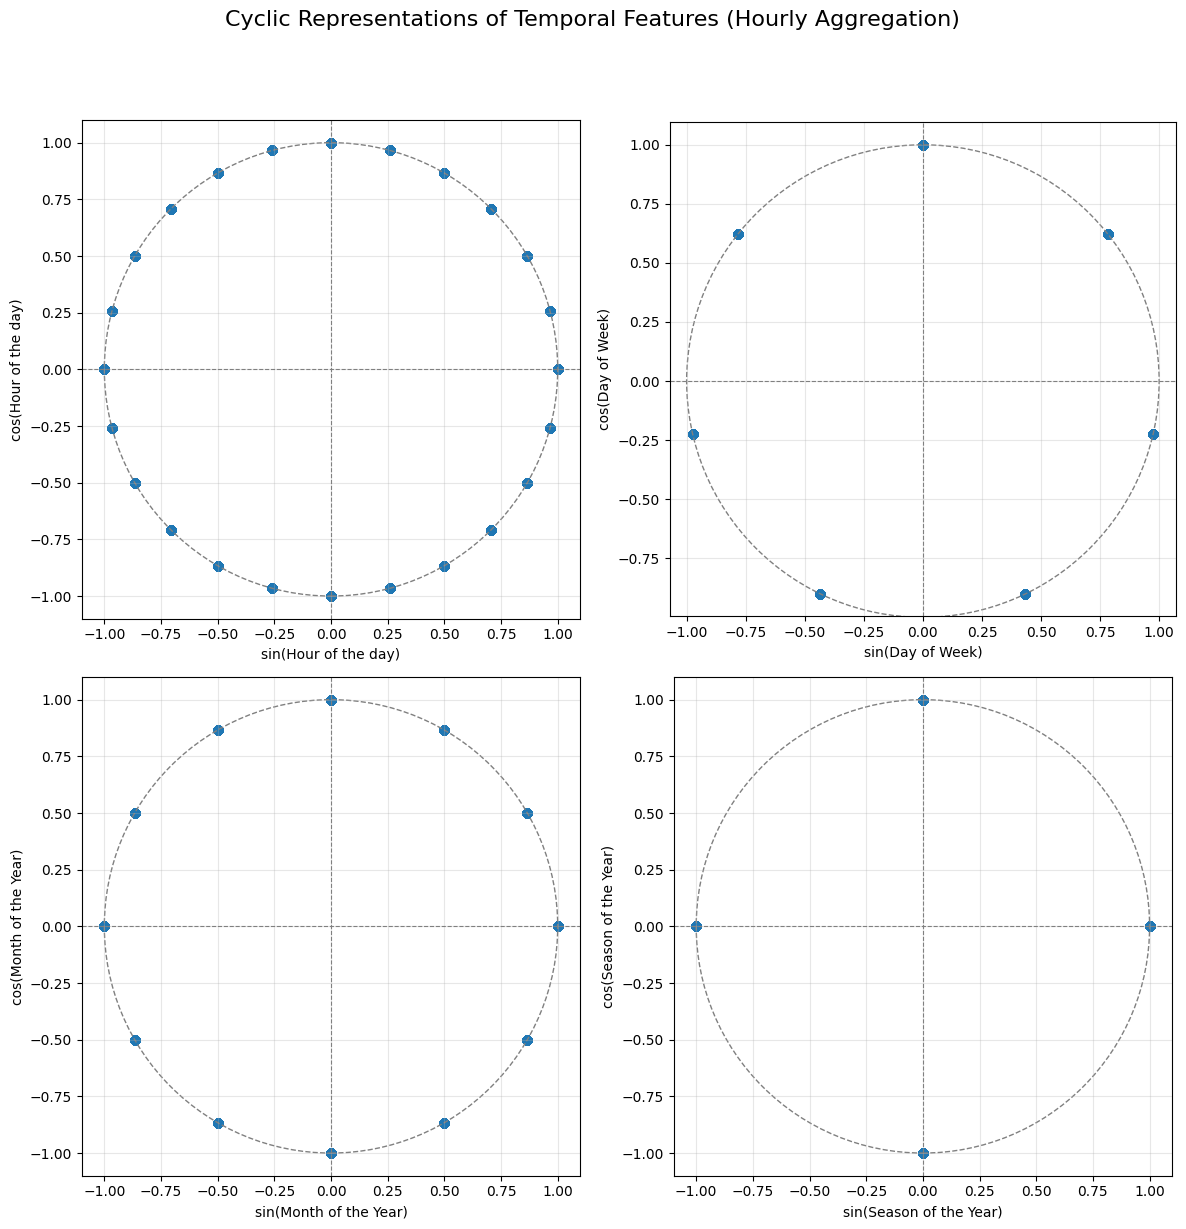

In [67]:
# List of variables to plot
cyclic_vars = [
    ("Trip Start Hour", "Hour of the day"),
    ("Trip Start Day", "Day of Week"),
    ("Trip Start Month", "Month of the Year"),
    ("Season", "Season of the Year")  # Example extra if available
]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Cyclic Representations of Temporal Features (Hourly Aggregation)", fontsize=16, y=1.02)

for ax, (var_prefix, var_label) in zip(axes.flatten(), cyclic_vars):
    sin_col = f"{var_prefix} Sin"
    cos_col = f"{var_prefix} Cos"

    # Plot sin vs cos
    ax.scatter(chicago_trips_hourly[sin_col], chicago_trips_hourly[cos_col], alpha=0.7)
    
    # Reference circle
    circle = plt.Circle((0, 0), 1, color="gray", fill=False, linestyle="dashed", linewidth=1)
    ax.add_artist(circle)
    
    # Axes formatting
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.axvline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.set_xlabel(f"sin({var_label})")
    ax.set_ylabel(f"cos({var_label})")
    ax.grid(alpha=0.3)
    ax.set_aspect('equal')

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave room for suptitle
plt.show()


# Visualization: 2-Hourly Time Data Cyclic Transformation

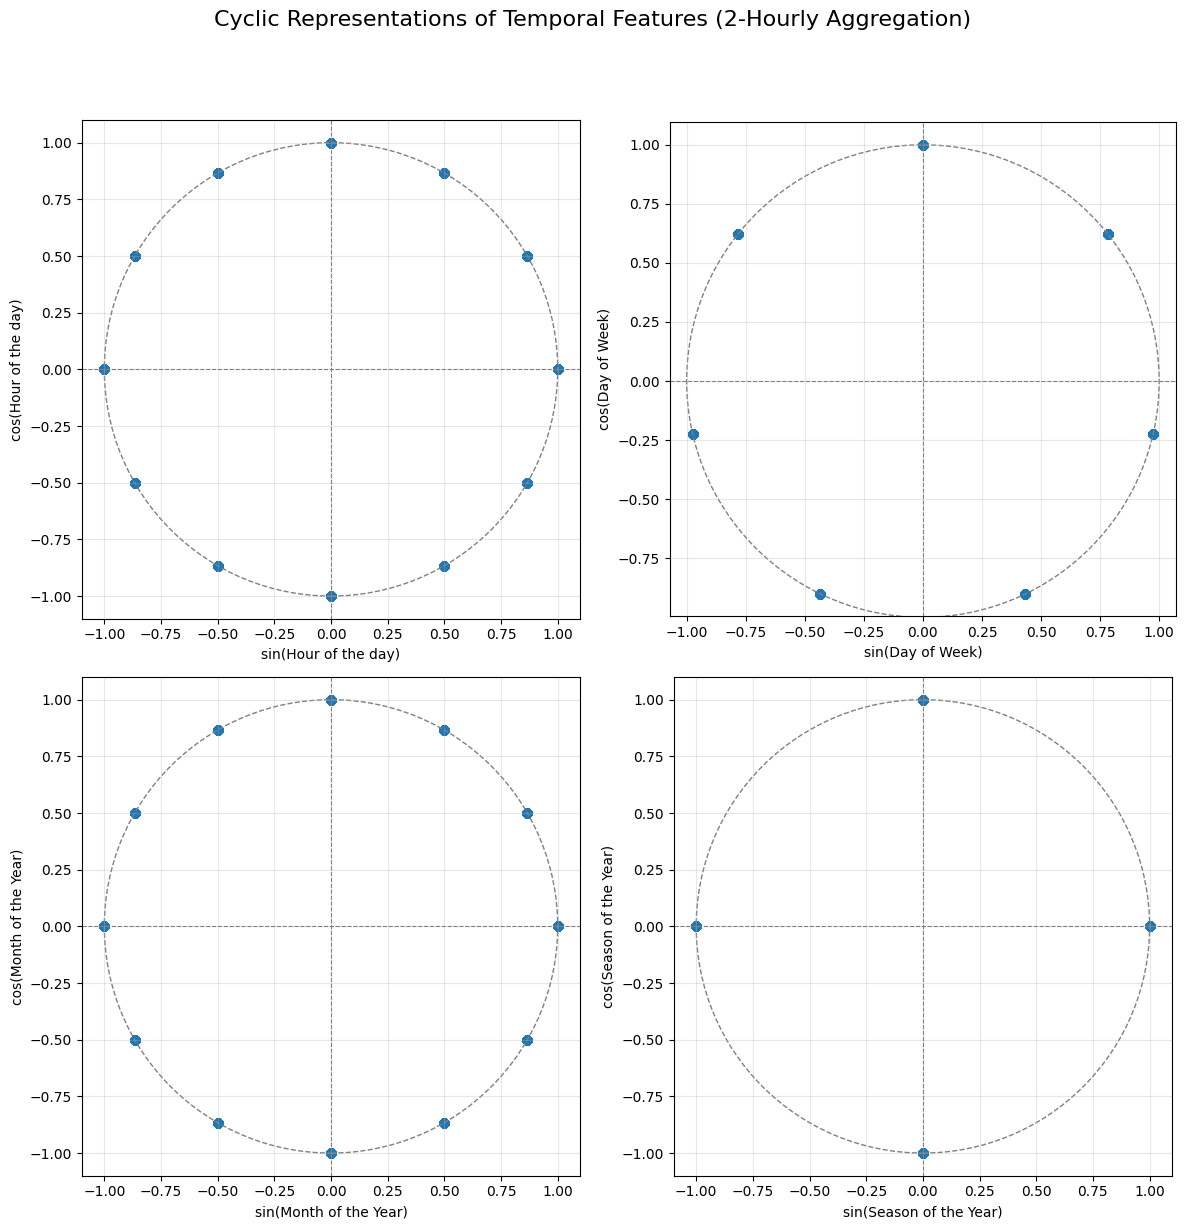

In [68]:
# List of variables to plot
cyclic_vars = [
    ("Trip Start Hour", "Hour of the day"),
    ("Trip Start Day", "Day of Week"),
    ("Trip Start Month", "Month of the Year"),
    ("Season", "Season of the Year")  # Example extra if available
]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Cyclic Representations of Temporal Features (2-Hourly Aggregation)", fontsize=16, y=1.02)

for ax, (var_prefix, var_label) in zip(axes.flatten(), cyclic_vars):
    sin_col = f"{var_prefix} Sin"
    cos_col = f"{var_prefix} Cos"

    # Plot sin vs cos
    ax.scatter(chicago_trips_2_hourly[sin_col], chicago_trips_2_hourly[cos_col], alpha=0.7)
    
    # Reference circle
    circle = plt.Circle((0, 0), 1, color="gray", fill=False, linestyle="dashed", linewidth=1)
    ax.add_artist(circle)
    
    # Axes formatting
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.axvline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.set_xlabel(f"sin({var_label})")
    ax.set_ylabel(f"cos({var_label})")
    ax.grid(alpha=0.3)
    ax.set_aspect('equal')

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave room for suptitle
plt.show()


# Visualization: 6-Hourly Time Data Cyclic Transformation

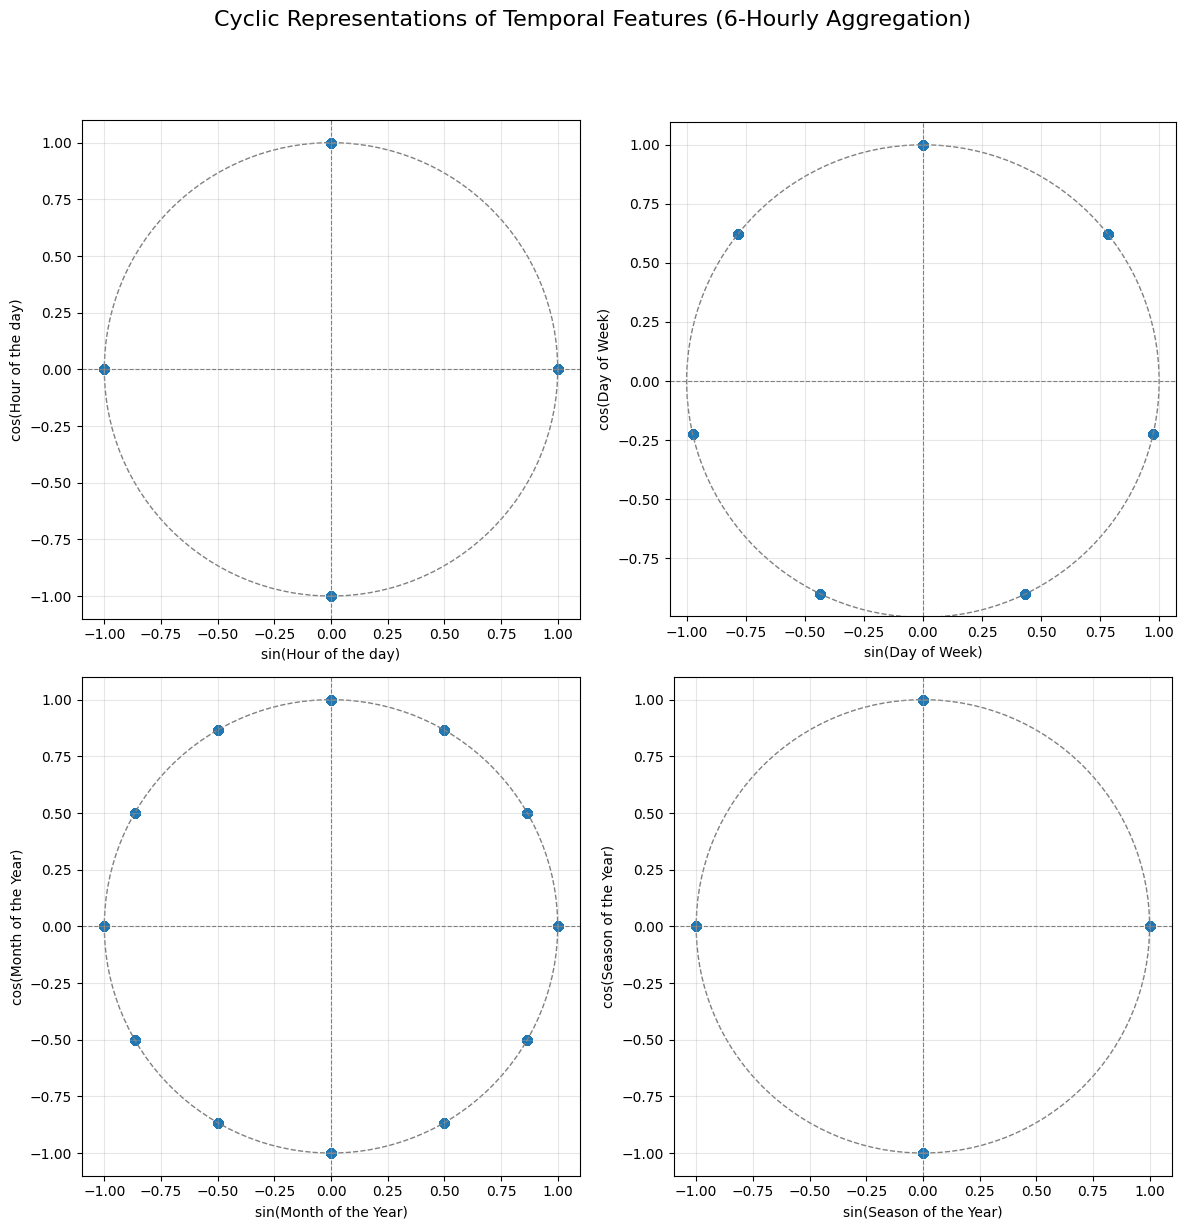

In [71]:
# List of variables to plot
cyclic_vars = [
    ("Trip Start Hour", "Hour of the day"),
    ("Trip Start Day", "Day of Week"),
    ("Trip Start Month", "Month of the Year"),
    ("Season", "Season of the Year")  # Example extra if available
]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Cyclic Representations of Temporal Features (6-Hourly Aggregation)", fontsize=16, y=1.02)

for ax, (var_prefix, var_label) in zip(axes.flatten(), cyclic_vars):
    sin_col = f"{var_prefix} Sin"
    cos_col = f"{var_prefix} Cos"

    # Plot sin vs cos
    ax.scatter(chicago_trips_6_hourly[sin_col], chicago_trips_6_hourly[cos_col], alpha=0.7)
    
    # Reference circle
    circle = plt.Circle((0, 0), 1, color="gray", fill=False, linestyle="dashed", linewidth=1)
    ax.add_artist(circle)
    
    # Axes formatting
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.axvline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.set_xlabel(f"sin({var_label})")
    ax.set_ylabel(f"cos({var_label})")
    ax.grid(alpha=0.3)
    ax.set_aspect('equal')

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave room for suptitle
plt.show()


# Visualization: 12-Hourly Time Data Cyclic Transformation

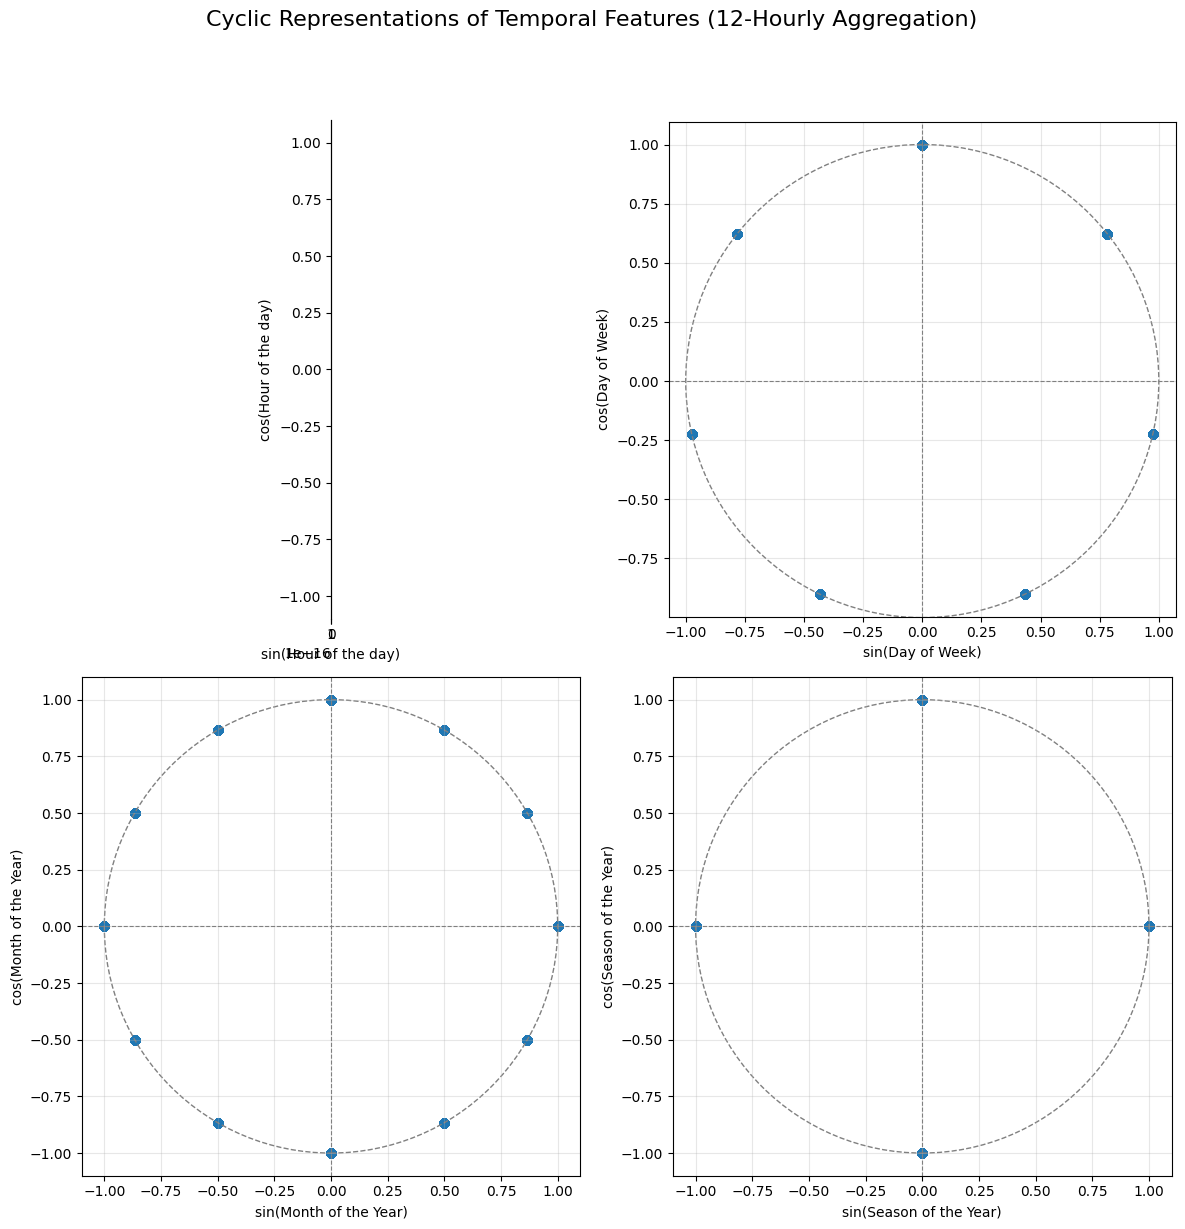

In [75]:
# List of variables to plot
cyclic_vars = [
    ("Trip Start Hour", "Hour of the day"),
    ("Trip Start Day", "Day of Week"),
    ("Trip Start Month", "Month of the Year"),
    ("Season", "Season of the Year")  # Example extra if available
]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Cyclic Representations of Temporal Features (12-Hourly Aggregation)", fontsize=16, y=1.02)

for ax, (var_prefix, var_label) in zip(axes.flatten(), cyclic_vars):
    sin_col = f"{var_prefix} Sin"
    cos_col = f"{var_prefix} Cos"

    # Plot sin vs cos
    ax.scatter(chicago_trips_12_hourly[sin_col], chicago_trips_12_hourly[cos_col], alpha=0.7)
    
    # Reference circle
    circle = plt.Circle((0, 0), 1, color="gray", fill=False, linestyle="dashed", linewidth=1)
    ax.add_artist(circle)
    
    # Axes formatting
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.axvline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.set_xlabel(f"sin({var_label})")
    ax.set_ylabel(f"cos({var_label})")
    ax.grid(alpha=0.3)
    ax.set_aspect('equal')

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave room for suptitle
plt.show()


# Visualization: Daily Time Data Cyclic Transformation

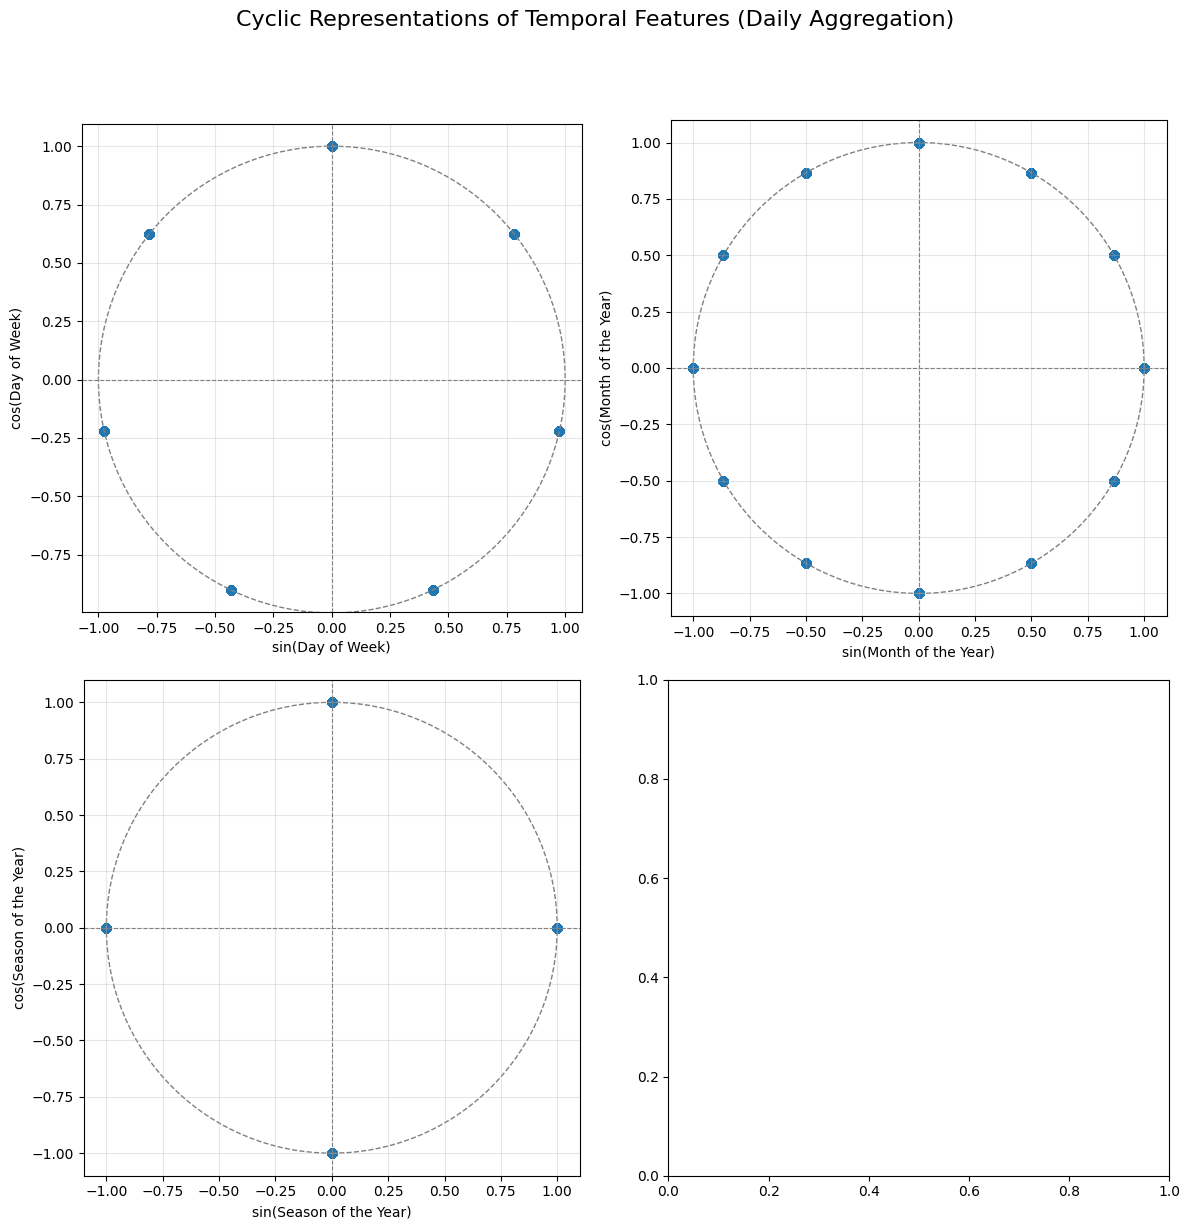

In [73]:
# List of variables to plot
cyclic_vars = [
    ("Trip Start Day", "Day of Week"),
    ("Trip Start Month", "Month of the Year"),
    ("Season", "Season of the Year")  # Example extra if available
]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Cyclic Representations of Temporal Features (Daily Aggregation)", fontsize=16, y=1.02)

for ax, (var_prefix, var_label) in zip(axes.flatten(), cyclic_vars):
    sin_col = f"{var_prefix} Sin"
    cos_col = f"{var_prefix} Cos"

    # Plot sin vs cos
    ax.scatter(chicago_trips_daily[sin_col], chicago_trips_daily[cos_col], alpha=0.7)
    
    # Reference circle
    circle = plt.Circle((0, 0), 1, color="gray", fill=False, linestyle="dashed", linewidth=1)
    ax.add_artist(circle)
    
    # Axes formatting
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.axvline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.set_xlabel(f"sin({var_label})")
    ax.set_ylabel(f"cos({var_label})")
    ax.grid(alpha=0.3)
    ax.set_aspect('equal')

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave room for suptitle
plt.show()
